1) TESTING DIFFERENT MODELS TO PREDICT INDEX PERFORMANCE

 i. LSTM
 ii. ARIMA
 iii. RANDOM FOREST
 iv. SUPPORT VECTOR MACHINE

2) PROPOSALS OF INVESTMENTS PORTFOLIOS

 i. Markowitz’s Minimum-Variance Portfolio (MVP)
 ii. Traditional risk parity’s Inverse-Variance Portfolio (IVP)
 iii. Hierarchical Risk Parity (HRP)

In [1]:
#Defining libraries and dependencies
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import quandl 

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
quandl.ApiConfig.api_key = "qrtyy6k9BVDXhBK7AYo4"

%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import SGD



import scipy.cluster.hierarchy as sch
from datetime import date
from matplotlib import pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
from alpha_vantage.timeseries import TimeSeries
import ffn
import config
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


i. TimeSeriesPrediction_LSTM

In [2]:
#Getting Data
aapl = quandl.get("WIKI/AAPL", start_date="2010-01-01", end_date="2019-05-01")
aapl.to_csv('Resources/aapl_ohlc.csv')
df = pd.read_csv('Resources/aapl_ohlc.csv', header=0, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,17633200.0,0.0,1.0,27.428730,27.566240,27.293790,27.503268,123432400.0
2010-01-05,214.60,215.59,213.25,214.38,21496600.0,0.0,1.0,27.579091,27.706320,27.405597,27.550818,150476200.0
2010-01-06,214.38,215.23,210.75,210.97,19720000.0,0.0,1.0,27.550818,27.660055,27.084312,27.112585,138040000.0
2010-01-07,211.75,212.00,209.05,210.58,17040400.0,0.0,1.0,27.212826,27.244955,26.865839,27.062465,119282800.0
2010-01-08,210.30,212.00,209.06,211.98,15986100.0,0.0,1.0,27.026481,27.244955,26.867124,27.242385,111902700.0


In [3]:
df=df[['Close']] 
df.head()

,Close
Date,
2010-01-04,214.01
2010-01-05,214.38
2010-01-06,210.97
2010-01-07,210.58
2010-01-08,211.98


In [4]:
dataset = df

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
print(dataset[:20])

[[0.20223268]
 [0.20283744]
 [0.1972639 ]
 [0.19662646]
 [0.19891471]
 [0.19585826]
 [0.19195188]
 [0.19674087]
 [0.19474682]
 [0.18902618]
 [0.20391618]
 [0.19849792]
 [0.19252721]
 [0.17565624]
 [0.18435978]
 [0.18904253]
 [0.19221993]
 [0.17817332]
 [0.16636102]
 [0.17072015]]


In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#print(len(train), len(test))

In [13]:
# convert an array of values into a dataset matrix
# Give X look_back time what will tomorrows prediction be?
def create_dataset(dataset, look_back=8):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [14]:
# reshape into X=t and Y=t+1
import numpy as np
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [15]:
trainX[1]

array([[0.20283744],
       [0.1972639 ],
       [0.19662646],
       [0.19891471],
       [0.19585826],
       [0.19195188],
       [0.19674087],
       [0.19474682],
       [0.18902618],
       [0.20391618]])

In [16]:
trainY[1]

0.19849792422607954

In [17]:
trainX.shape

(1375, 10, 1)

In [18]:
sgd = SGD(lr=0.1)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(1, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=sgd)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=20)])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 6s - loss: 0.0105
Epoch 2/50
 - 4s - loss: 0.0025
Epoch 3/50
 - 4s - loss: 0.0020
Epoch 4/50
 - 4s - loss: 0.0017
Epoch 5/50
 - 4s - loss: 0.0015
Epoch 6/50
 - 4s - loss: 0.0014
Epoch 7/50
 - 4s - loss: 0.0013
Epoch 8/50
 - 5s - loss: 0.0012
Epoch 9/50
 - 5s - loss: 0.0012
Epoch 10/50
 - 5s - loss: 0.0012
Epoch 11/50
 - 4s - loss: 0.0012
Epoch 12/50
 - 5s - loss: 0.0011
Epoch 13/50
 - 4s - loss: 0.0011
Epoch 14/50
 - 5s - loss: 0.0011
Epoch 15/50
 - 5s - loss: 0.0011
Epoch 16/50
 - 5s - loss: 0.0010
Epoch 17/50
 - 5s - loss: 0.0010
Epoch 18/50
 - 5s - loss: 0.0010
Epoch 19/50
 - 4s - loss: 0.0010
Epoch 20/50
 - 4s - loss: 9.8218e-04
Epoch 21/50
 - 5s - loss: 9.8596e-04
Epoch 22/50
 - 4s - loss: 9.6781e-04
Epoch 23/50
 - 4s - loss: 9.6286e-04
Epoch 24/50
 - 5s - loss: 9.5966e-04
Epoch 25/50
 - 5s - loss: 9.5916e-04
Epoch 26/50
 - 5s - loss: 9.4558e-04
Epoch 27/50
 - 4s - loss: 9.4705e-04
Epoch 28/50
 - 5s - loss: 9.3351e-04
E

In [25]:
model.save("aapl_ohlc.h5")

In [26]:
from keras.models import load_model
model = load_model("aapl_ohlc.h5")

In [27]:
trainX[0]

array([[0.20223268],
       [0.20283744],
       [0.1972639 ],
       [0.19662646],
       [0.19891471],
       [0.19585826],
       [0.19195188],
       [0.19674087],
       [0.19474682],
       [0.18902618]])

In [28]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [29]:
fake_10 = [[100,101,110,105,100,101,110,105,120,130]]
processed_fake_10 = scaler.transform(fake_10)
processed_fake_10.reshape(1,10,1)
output = model.predict(processed_fake_10.reshape(1,10,1))
scaler.inverse_transform(output)

array([[131.1957]], dtype=float32)

In [30]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [31]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.93 RMSE
Test Score: 2.17 RMSE


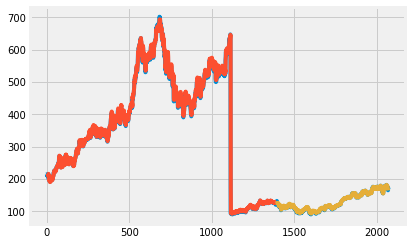

In [34]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ii. Autoregressive integrated moving average (ARIMA)

In [35]:
df=df[['Close']] 
df.head()

,Close
Date,
2010-01-04,214.01
2010-01-05,214.38
2010-01-06,210.97
2010-01-07,210.58
2010-01-08,211.98


In [36]:
y=df
y.head()

,Close
Date,
2010-01-04,214.01
2010-01-05,214.38
2010-01-06,210.97
2010-01-07,210.58
2010-01-08,211.98


In [37]:
# The 'MS' string groups the data in buckets by start of the month
y = y['Close'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)

Date
2010-01-01    207.715737
2010-02-01    198.795000
2010-03-01    223.410648
2010-04-01    251.148548
2010-05-01    251.461200
2010-06-01    261.145864
2010-07-01    254.949476
2010-08-01    251.323227
2010-09-01    273.851143
2010-10-01    300.934286
2010-11-01    311.587857
2010-12-01    321.486023
2011-01-01    338.380250
2011-02-01    351.182632
2011-03-01    347.490761
2011-04-01    340.415250
2011-05-01    341.784762
2011-06-01    331.081455
2011-07-01    372.238000
2011-08-01    376.762609
2011-09-01    392.493333
2011-10-01    397.230000
2011-11-01    384.815238
2011-12-01    392.930238
2012-01-01    428.577950
2012-02-01    497.571000
2012-03-01    577.507727
2012-04-01    606.003000
2012-05-01    564.672955
2012-06-01    574.561952
                 ...    
2015-10-01    113.360000
2015-11-01    118.162250
2015-12-01    111.726818
2016-01-01     98.428947
2016-02-01     95.746500
2016-03-01    104.267273
2016-04-01    106.739048
2016-05-01     94.974762
2016-06-01     96.62

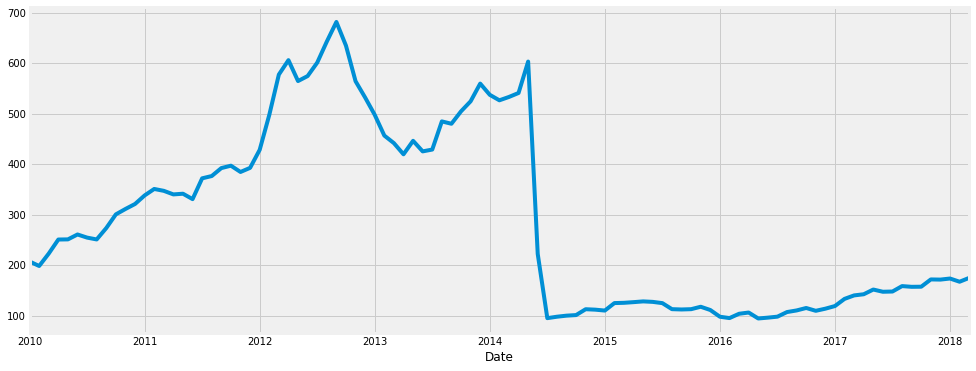

In [38]:
y.plot(figsize=(15, 6))
plt.show()

In [39]:
#Parameter Selection for the ARIMA Time Series Model


# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [40]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1423.1031438224668
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1197.7525046528249
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1142.4926076201778
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:993.0443510160255
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1149.017543496608
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1137.8454363668984
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1005.6230717164717
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:992.2564952105623
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1291.0558966310766
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1086.4549545840193
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1041.8591591663474
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:904.0826051234162
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1059.2397971463795
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1037.57267868767
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:928.0017887474656
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:905.8604491617205
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1022.5057185107743
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:908.0458979038425
A

In [41]:
#Fitting an ARIMA Time Series Model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2138      0.943     -0.227      0.821      -2.061       1.634
ma.L1          0.4356      0.903      0.483      0.629      -1.334       2.205
ar.S.L12      -0.0075      0.105     -0.072      0.943      -0.213       0.198
ma.S.L12      -1.0000      0.064    -15.504      0.000      -1.126      -0.874
sigma2      2335.8391   2.76e-05   8.46e+07      0.000    2335.839    2335.839


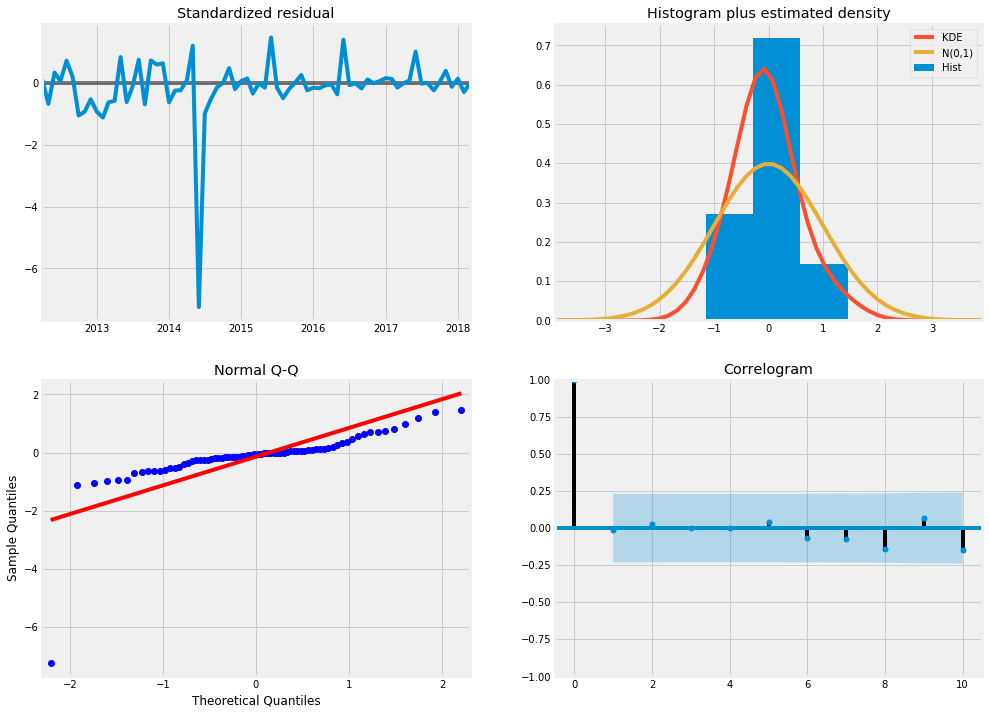

In [42]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [43]:
# Validating Forecasts
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()

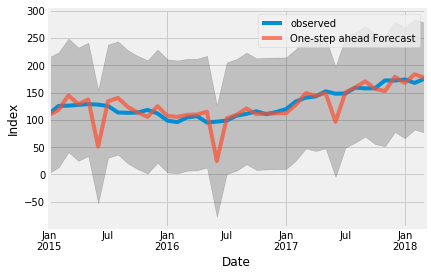

In [44]:
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Index')
plt.legend()

plt.show()

In [45]:
y_forecasted = pred.predicted_mean
y_truth = y['2015-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 445.39


In [46]:
# A better representation of our true predictive power can be obtained using dynamic 
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

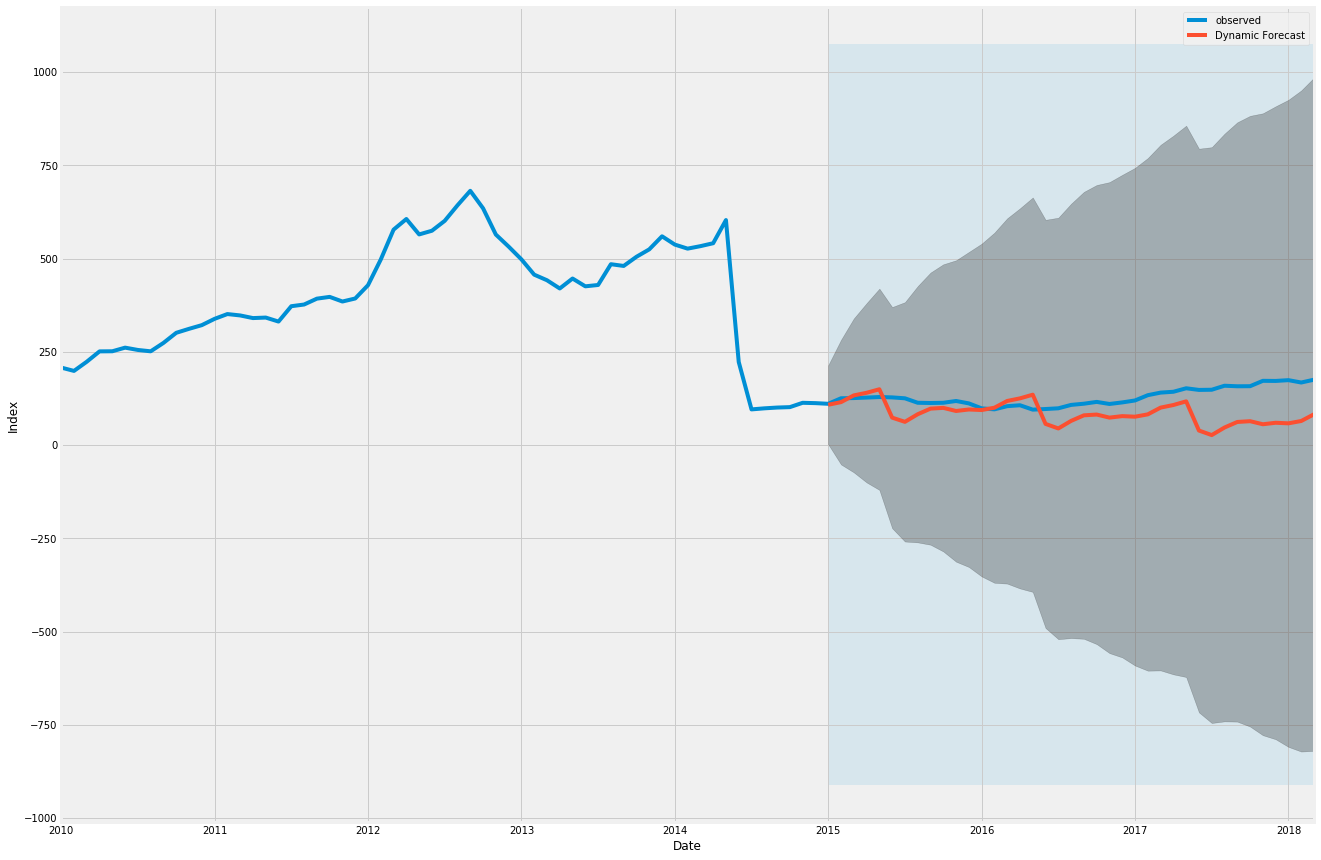

In [48]:
ax = y['2010':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Index')

plt.legend()
plt.show()

In [49]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2015-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3792.71


In [50]:
#Producing and Visualizing Forecasts


# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

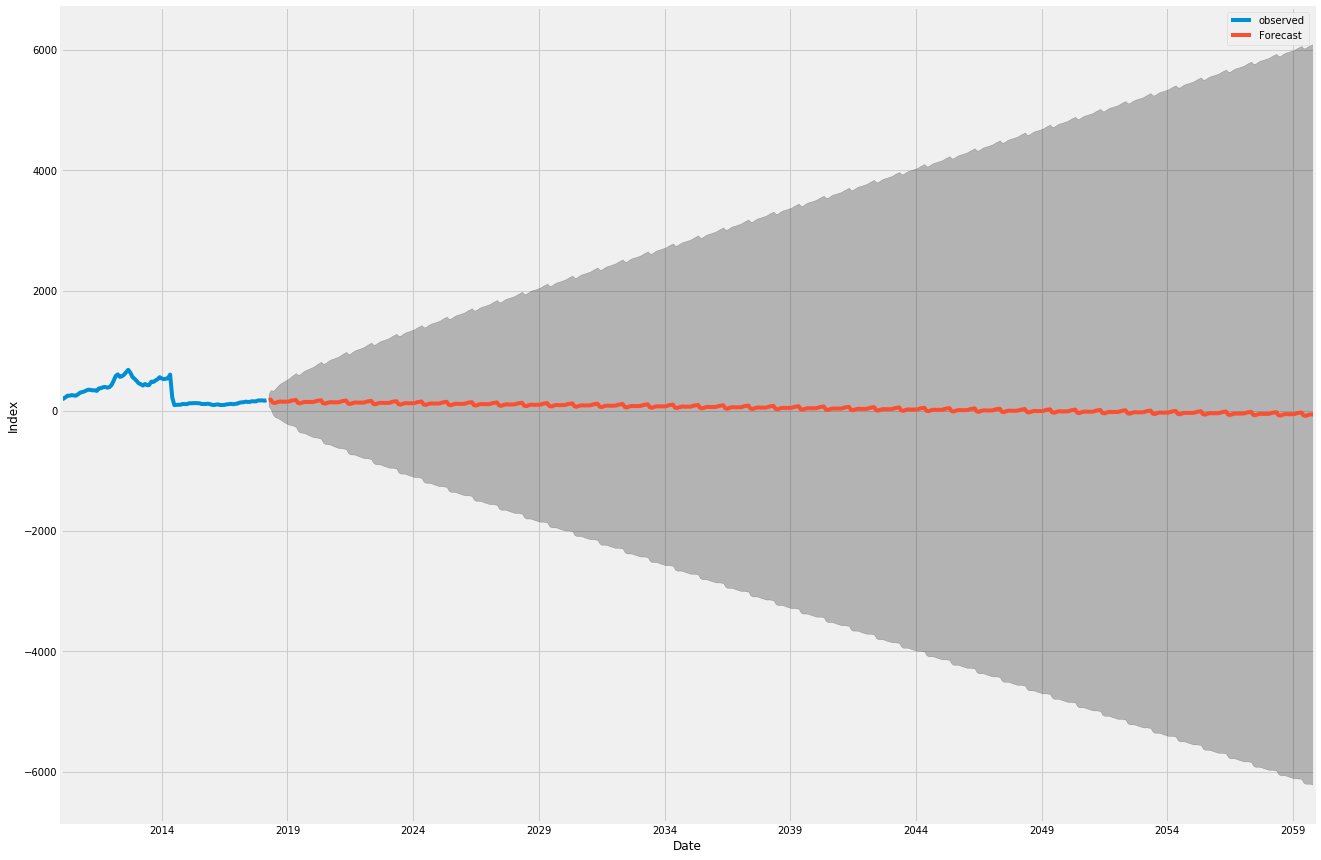

In [60]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Index')

plt.legend()
plt.show()

iii. RANDOM FOREST REGRESSION


In [61]:
df=df[['Close']]
df['X'] = range(1, len(df) + 1)
df = df[['X', 'Close']]
df.head()

,X,Close
Date,,
2010-01-04,1,214.01
2010-01-05,2,214.38
2010-01-06,3,210.97
2010-01-07,4,210.58
2010-01-08,5,211.98


In [62]:
df.as_matrix()
df_to_nparray = df.to_records(index=False)
df_to_nparray


rec.array([(   1, 214.01), (   2, 214.38), (   3, 210.97), ...,
           (2068, 164.94), (2069, 172.77), (2070, 168.34)],
          dtype=[('X', '<i4'), ('Close', '<f8')])

In [63]:
df_to_nparray=df_to_nparray.reshape(-1, 1)

In [64]:
X=df_to_nparray['X']
y=df_to_nparray['Close']

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

In [66]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

In [67]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)  

In [68]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 3.571075567632851
Mean Squared Error: 119.2186502288703
Root Mean Squared Error: 10.918729332155381


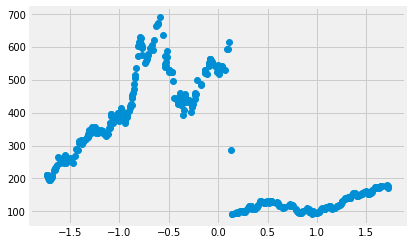

In [69]:
#plots https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html
plt.errorbar(X_test, y_pred, 0.3, fmt='o');

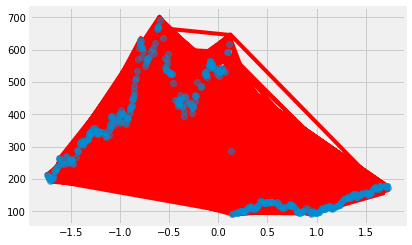

In [70]:
from sklearn.ensemble import RandomForestRegressor

plt.errorbar(X_test, y_pred, 0.3, fmt='o', alpha=0.5)
plt.plot(X_train, y_train, '-r');


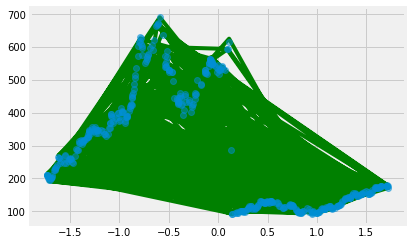

In [71]:
plt.errorbar(X_test, y_pred, 0.3, fmt='o', alpha=0.5)
#plt.plot(X_train, y_train, '-r');
plt.plot(X_test, y_test, '-g');

iv. Support Vector Machine

In [81]:
X=df_to_nparray['X']
y=df_to_nparray['Close']

In [82]:
df_to_nparray=df_to_nparray.reshape(-1, 1)

In [83]:
# Add noise to targets
y += 3 * (0.5 - y)


In [84]:
from sklearn.svm import SVR 
from sklearn.metrics import mean_squared_error 
model = SVR()
print(model)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [85]:
model.fit(X,y)
pred_y = model.predict(X)
pred_y

array([971.14548631, 970.77760687, 970.75929123, ..., 970.75929123,
       970.77760687, 971.14548631])

In [86]:
X=df_to_nparray['X']
y=df_to_nparray['Close']

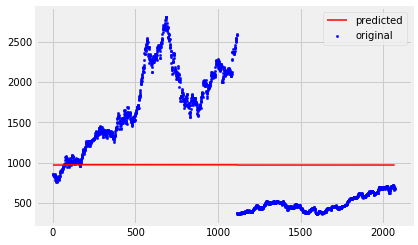

In [87]:
plt.scatter(X, y, s=5, color="blue", label="original")
plt.plot(X, pred_y, lw=1.5, color="red", label="predicted")
plt.legend()
plt.show() 

In [88]:
model =SVR()
print(model)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [89]:
model.fit(X,y)
pred_y = model.predict(X)
pred_y

array([971.14548631, 970.77760687, 970.75929123, ..., 970.75929123,
       970.77760687, 971.14548631])

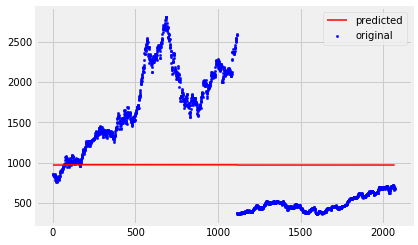

In [90]:
plt.scatter(X, y, s=5, color="blue", label="original")
plt.plot(X, pred_y, lw=1.5, color="red", label="predicted")
plt.legend()
plt.show() 

In [91]:
model =SVR()
print(model)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='Polynomial', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='Polynomial', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [92]:
model.fit(X,y)
pred_y = model.predict(X)
pred_y

array([971.14548631, 970.77760687, 970.75929123, ..., 970.75929123,
       970.77760687, 971.14548631])

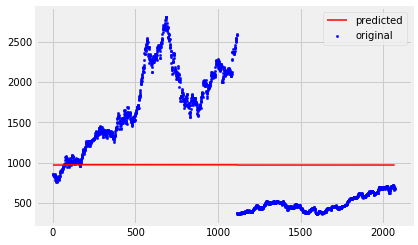

In [93]:
plt.scatter(X, y, s=5, color="blue", label="original")
plt.plot(X, pred_y, lw=1.5, color="red", label="predicted")
plt.legend()
plt.show() 

2) Investment Portfolios

In [94]:
# On 20151227 by MLdP <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity


def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp


def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar


def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()


def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist


def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #dn = sch.dendrogram(link, labels=cov.index.values, label_rotation=90)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [95]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

In [96]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    portfolios = pd.DataFrame([mvp, ivp, hrp], index=['MVP', 'IVP', 'HRP']).T
    
    return portfolios

In [97]:
stocks = {
    "Apple": "AAPL",
    "Amazon": "AMZN",
    "Alphabet": "GOOG",
    "Microsoft": "MSFT",
    "Alibaba": "BABA"
#    # "Diversified Fixed Income Portfolio":"DFXIX"
#     "STANDARD POORS":"SPX"
}
stock_df = pd.DataFrame()
stock_symbols = list(stocks.values())# stocks = pd.DataFrame(list(stocks.items()), columns=["name", "symbol"])
ts = TimeSeries(key="VW8RXL88BTZWTRN4",output_format='pandas')
symbols = []
for symbol in stock_symbols:
    symbols.append(symbol)
    print(symbol)
    data, _ = ts.get_daily(symbol=symbol, outputsize='full')
    close = data['4. close']
    stock_df = pd.concat([stock_df, close], axis=1)

AAPL
AMZN
GOOG
MSFT
BABA


In [98]:
stock_df.columns = symbols
stock_df

,AAPL,AMZN,GOOG,MSFT,BABA
1998-01-02,16.25,59.50,NaN,131.13,NaN
1998-01-05,15.88,57.00,NaN,130.38,NaN
1998-01-06,18.94,58.06,NaN,131.13,NaN
1998-01-07,17.50,57.38,NaN,129.56,NaN
1998-01-08,18.19,55.38,NaN,130.50,NaN
1998-01-09,18.19,51.13,NaN,127.00,NaN
1998-01-12,18.25,51.63,NaN,129.50,NaN
1998-01-13,19.50,55.75,NaN,132.13,NaN
1998-01-14,19.75,58.50,NaN,131.13,NaN
1998-01-15,19.19,59.44,NaN,132.31,NaN


In [99]:
range_stock_df = stock_df["2010-01-01":"2019-05-01"]
returns = range_stock_df.to_returns().dropna()
portfolios = get_all_portfolios(returns)


     pcost       dcost       gap    pres   dres
 0: -9.9999e-01 -2.0000e+00  1e+00  1e-16  1e+00
 1: -9.9999e-01 -1.0100e+00  1e-02  5e-17  1e-02
 2: -9.9999e-01 -1.0001e+00  1e-04  8e-17  1e-04
 3: -9.9999e-01 -9.9999e-01  3e-06  5e-17  4e-06
 4: -9.9999e-01 -9.9999e-01  4e-07  6e-17  1e-07
 5: -9.9999e-01 -9.9999e-01  4e-08  8e-17  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9999e-01 -2.0000e+00  1e+00  4e-16  1e+00
 1: -9.9999e-01 -1.0100e+00  1e-02  7e-17  1e-02
 2: -9.9999e-01 -1.0001e+00  1e-04  5e-17  1e-04
 3: -9.9999e-01 -9.9999e-01  3e-06  1e-16  4e-06
 4: -9.9999e-01 -9.9999e-01  4e-07  1e-16  1e-07
 5: -9.9999e-01 -9.9999e-01  4e-08  8e-17  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9999e-01 -2.0000e+00  1e+00  5e-16  1e+00
 1: -9.9999e-01 -1.0100e+00  1e-02  9e-17  1e-02
 2: -9.9999e-01 -1.0001e+00  1e-04  6e-17  1e-04
 3: -9.9999e-01 -9.9999e-01  4e-06  1e-16  4e-06
 4: -9.9999e-01 -9.9999e

 3: -9.9590e-01 -9.9600e-01  1e-04  1e-16  3e-05
 4: -9.9593e-01 -9.9594e-01  9e-06  1e-16  3e-17
 5: -9.9593e-01 -9.9593e-01  9e-07  1e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9506e-01 -1.9963e+00  1e+00  4e-16  1e+00
 1: -9.9506e-01 -1.0063e+00  1e-02  1e-16  1e-02
 2: -9.9521e-01 -9.9611e-01  9e-04  1e-16  1e-03
 3: -9.9540e-01 -9.9551e-01  1e-04  8e-17  4e-05
 4: -9.9543e-01 -9.9544e-01  1e-05  1e-16  6e-17
 5: -9.9544e-01 -9.9544e-01  9e-07  8e-17  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9445e-01 -1.9959e+00  1e+00  2e-15  1e+00
 1: -9.9446e-01 -1.0059e+00  1e-02  1e-16  1e-02
 2: -9.9463e-01 -9.9559e-01  1e-03  7e-17  1e-03
 3: -9.9484e-01 -9.9496e-01  1e-04  1e-16  4e-05
 4: -9.9487e-01 -9.9488e-01  1e-05  1e-16  5e-17
 5: -9.9488e-01 -9.9488e-01  9e-07  6e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9378e-01 -1.9954e+00  1e+00  9e-16  1e+00


     pcost       dcost       gap    pres   dres
 0: -9.9991e-01 -1.9999e+00  1e+00  3e-16  1e+00
 1: -9.9991e-01 -1.0099e+00  1e-02  6e-17  1e-02
 2: -9.9991e-01 -1.0000e+00  1e-04  8e-17  1e-04
 3: -9.9992e-01 -9.9993e-01  1e-05  8e-17  1e-05
 4: -9.9992e-01 -9.9992e-01  1e-06  1e-16  4e-07
 5: -9.9992e-01 -9.9992e-01  1e-07  2e-16  8e-17
Optimal solution found.


In [100]:
portfolios

,MVP,IVP,HRP
AAPL,0.308613,0.225684,0.299797
AMZN,0.015696,0.151459,0.176838
GOOG,0.295245,0.243431,0.171967
MSFT,0.276012,0.245399,0.173357
BABA,0.104434,0.134028,0.178042
